In [1]:
%pylab inline
import galsim
import fpfs
import impt
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from mpl_toolkits.axes_grid1 import ImageGrid

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


2023/08/14 08:49:04 ---  Processing for g1-2222, and shears for four redshift bins are [0.02 0.02 0.02 0.02].


Making Basic Simulation. ID: 2


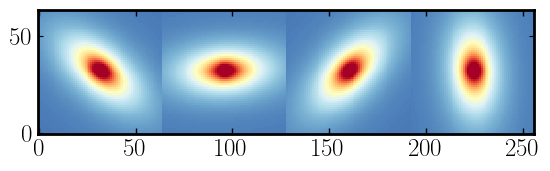

2023/08/14 08:49:11 ---  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023/08/14 08:49:11 ---  Order of the shear estimator: nnord=4
2023/08/14 08:49:11 ---  Shapelet kernel in configuration space: sigma= 0.1750 arcsec
2023/08/14 08:49:11 ---  Detection kernel in configuration space: sigma= 0.1750 arcsec


Input shear is: 0.020000
Estimated shear is: 0.020001


In [2]:
shear_value = 0.02
scale = 0.168/4
nx, ny = 64, 64
outDir='galaxy_basicCenter_psf60'
psfInt = galsim.Moffat(
    beta=3.5, fwhm=0.6/4, trunc=0.6 * 4.0
).shear(e1=0.02, e2=-0.02)
psfData = psfInt.shift(0.5 * scale, 0.5 * scale).drawImage(nx=nx, ny=ny, scale=scale).array

# Four Galaxies to cancel spin-2 and spin-4 ansiotropies
# spin-2 is shape noise in diagnonal elements of shear response matrix
# spin-4 is shape noise in diagnonal and of-diagnoal elements of shear response matrix, 
# but an order of magnitude smaller than spin-2
gal_data = fpfs.simutil.make_basic_sim(
    outDir,psf_obj=psfInt,gname='g1-2222',
    ind0=2,ny=ny,nx=nx*4, scale=scale,
    do_write=False,return_array=True,
    shear_value = shear_value, ngrid=nx)
plt.close()
plt.imshow(gal_data,aspect='equal',cmap='RdYlBu_r',origin='lower',interpolation='None',\
             norm=simple_norm(gal_data,'asinh',asinh_a=0.1,min_cut=-0.01,max_cut=0.3))
plt.show()
# Now we measure shear
rcut = 32

# fake detection
indX = np.arange(int(nx/2), nx*4, nx)
indY = np.arange(int(ny/2), ny, ny)
inds = np.meshgrid(indY, indX, indexing="ij")
coords = np.vstack(inds).T

fpTask  =   fpfs.image.measure_source(psfData,pix_scale = scale, sigma_arcsec=0.7/4)
mms =  fpTask.measure(gal_data, coords)
mms = fpTask.get_results(mms)
ells=   fpfs.catalog.fpfs_m2e(mms,const=2000)
resp=np.average(ells['fpfs_R1E'])
shear=np.average(ells['fpfs_e1'])/resp

print('Input shear is: %.6f' %shear_value)
print('Estimated shear is: %.6f' %shear)

2023/08/14 08:49:12 ---  Processing for g1-2222, and shears for four redshift bins are [0.02 0.02 0.02 0.02].


Making Basic Simulation. ID: 2


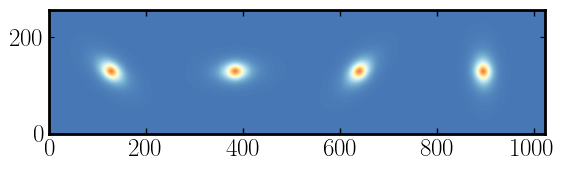

2023/08/14 08:49:13 ---  Order of the shear estimator: nnord=4
2023/08/14 08:49:13 ---  Shapelet kernel in configuration space: sigma= 0.7000 arcsec
2023/08/14 08:49:13 ---  Detection kernel in configuration space: sigma= 0.7000 arcsec


Input shear is: 0.020000
Estimated shear is: 0.020001


In [3]:
# s
shear_value = 0.02
scale = 0.168/4
nx, ny = 256, 256
outDir='galaxy_basicCenter_psf60'
psfInt = galsim.Moffat(
    beta=3.5, fwhm=0.6, trunc=0.6 * 4.0
).shear(e1=0.02, e2=-0.02)
psfData = psfInt.shift(0.5 * scale, 0.5 * scale).drawImage(nx=nx, ny=ny, scale=scale).array

# Four Galaxies to cancel spin-2 and spin-4 ansiotropies
# spin-2 is shape noise in diagnonal elements of shear response matrix
# spin-4 is shape noise in diagnonal and of-diagnoal elements of shear response matrix, 
# but an order of magnitude smaller than spin-2
gal_data = fpfs.simutil.make_basic_sim(
    outDir,psf_obj=psfInt,gname='g1-2222',
    ind0=2,ny=ny,nx=nx*4, scale=scale,
    do_write=False,return_array=True,
    shear_value = shear_value, ngrid=nx)
plt.close()
plt.imshow(gal_data,aspect='equal',cmap='RdYlBu_r',origin='lower',interpolation='None',\
             norm=simple_norm(gal_data,'asinh',asinh_a=0.1,min_cut=-0.01,max_cut=0.3))
plt.show()
# Now we measure shear
rcut = 32

# fake detection
indX = np.arange(int(nx/2), nx*4, nx)
indY = np.arange(int(ny/2), ny, ny)
inds = np.meshgrid(indY, indX, indexing="ij")
coords = np.vstack(inds).T

fpTask  =   fpfs.image.measure_source(psfData,pix_scale = scale, sigma_arcsec=0.7)
mms =  fpTask.measure(gal_data, coords)
mms = fpTask.get_results(mms)
ells=   fpfs.catalog.fpfs_m2e(mms,const=2000)
resp=np.average(ells['fpfs_R1E'])
shear=np.average(ells['fpfs_e1'])/resp

print('Input shear is: %.6f' %shear_value)
print('Estimated shear is: %.6f' %shear)